In [3]:
# ===========================================
# Final Team Project - Full Machine Learning Pipeline
# ===========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix,
    ConfusionMatrixDisplay, roc_curve, auc
)
import os

In [22]:
# Download data folder from GitHub
!wget --no-cache --output-document=psam_p06.csv https://raw.githubusercontent.com/vxdao01/504/modeling/csv_pca/psam_p06.csv

--2025-08-10 06:13:28--  https://raw.githubusercontent.com/vxdao01/504/modeling/csv_pca/psam_p06.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 134 [text/plain]
Saving to: ‘psam_p06.csv’

psam_p06.csv        100%[===================>]     134  --.-KB/s    in 0s      

2025-08-10 06:13:28 (11.2 MB/s) - ‘psam_p06.csv’ saved [134/134]



In [10]:
# Download second data set from GitHub
!wget https://github.com/vxdao01/504/tree/modeling/census-income

--2025-08-10 05:32:10--  https://github.com/vxdao01/504/tree/modeling/census-income
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘census-income’

census-income           [ <=>                ] 175.96K   993KB/s    in 0.2s    

2025-08-10 05:32:10 (993 KB/s) - ‘census-income’ saved [180183]



In [29]:
!apt-get install git-lfs
!git lfs install
!git clone https://github.com/vxdao01/504
%cd 504
!git lfs pull

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Git LFS initialized.
fatal: destination path '504' already exists and is not an empty directory.
/content/504


In [32]:
!git checkout modeling

Branch 'modeling' set up to track remote branch 'modeling' from 'origin'.
Switched to a new branch 'modeling'


In [33]:
# !pwd
!ls
# os.chdir('/content/drive/My Drive/Colab Notebooks/ADS-504-Final-Project')

504-final-project.ipynb  census+income.zip  final-edit-cv.ipynb
census-income		 csv_pca	    final-edit.ipynb


In [12]:
# === NEW GOOGLE COLAB FILE PATHS ===
train_path = "/content/drive/My Drive/Colab Notebooks/ADS-504-Final-Project/adult.data"
test_path = "/content/drive/My Drive/Colab Notebooks/ADS-504-Final-Project/adult.test"

# === FILE PATHS ===
# train_path = r"C:\Users\User\Downloads\census+income\adult.data"
# test_path = r"C:\Users\User\Downloads\census+income\adult.test"

In [ ]:
# === COLUMN NAMES ===
columns = [
    "age", "workclass", "fnlwgt", "education", "education_num", "marital_status",
    "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss",
    "hours_per_week", "native_country", "income"
]

# === 1. DATASET INTRODUCTION ===
print("📌 PROJECT INTRODUCTION:")
print("""
The goal of this project is to predict whether an individual earns more than $50K per year
based on demographic and employment attributes from the UCI Adult Census dataset.

This problem is important because it demonstrates how demographic and employment features
can be leveraged to identify income patterns. Machine learning models can help in policy-making,
targeted services, and socio-economic research by revealing key factors that influence income levels.
""")

# === LOAD DATA ===
df_train = pd.read_csv(train_path, header=None, names=columns, na_values=" ?", skipinitialspace=True)
df_test = pd.read_csv(test_path, header=None, names=columns, na_values=" ?", skipinitialspace=True, comment='|', skiprows=1)
df = pd.concat([df_train, df_test], ignore_index=True)

print(f"\n✅ Dataset loaded successfully. Shape: {df.shape}")

# === VARIABLE DESCRIPTIONS ===
var_desc = pd.DataFrame({
    "Feature": columns,
    "Description": [
        "Age of the individual",
        "Type of employment",
        "Census final weight (sample size indicator)",
        "Highest level of education attained",
        "Number of years of education",
        "Marital status",
        "Occupation type",
        "Relationship status",
        "Race",
        "Gender",
        "Capital gain",
        "Capital loss",
        "Average hours worked per week",
        "Country of origin",
        "Income class (<=50K or >50K)"
    ],
    "Type": ["Numeric", "Categorical", "Numeric", "Categorical", "Numeric", "Categorical",
             "Categorical", "Categorical", "Categorical", "Categorical", "Numeric",
             "Numeric", "Numeric", "Categorical", "Target"]
})
print("\n📊 Variable Descriptions:")
print(var_desc)

# === 2. PREPROCESSING ===
print("\n🧹 PREPROCESSING STARTED...")

# Drop missing values
df.dropna(inplace=True)

# Remove extra spaces
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Fix target variable encoding
df["income"] = df["income"].replace({">50K.": ">50K", "<=50K.": "<=50K"}).map({"<=50K": 0, ">50K": 1})

# Remove duplicates
df.drop_duplicates(inplace=True)

print(f"✅ Data cleaned. New shape: {df.shape}")

📌 PROJECT INTRODUCTION:

The goal of this project is to predict whether an individual earns more than $50K per year
based on demographic and employment attributes from the UCI Adult Census dataset.

This problem is important because it demonstrates how demographic and employment features
can be leveraged to identify income patterns. Machine learning models can help in policy-making,
targeted services, and socio-economic research by revealing key factors that influence income levels.


✅ Dataset loaded successfully. Shape: (48842, 15)

📊 Variable Descriptions:
           Feature                                  Description         Type
0              age                        Age of the individual      Numeric
1        workclass                           Type of employment  Categorical
2           fnlwgt  Census final weight (sample size indicator)      Numeric
3        education          Highest level of education attained  Categorical
4    education_num                 Number of year

/tmp/ipython-input-4135311693.py:60: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


✅ Data cleaned. New shape: (48790, 15)


In [34]:
# Read ACS PUMS data for California into dataframe
df2 = pd.read_csv('csv_pca/psam_p06.csv')

In [36]:
print(df2.head())

  RT       SERIALNO  DIVISION  SPORDER  PUMA  REGION  STATE   ADJINC  PWGTP  \
0  P  2023GQ0000009         9        1  5924       4      6  1019518     85   
1  P  2023GQ0000028         9        1  8515       4      6  1019518     60   
2  P  2023GQ0000030         9        1  2500       4      6  1019518     27   
3  P  2023GQ0000033         9        1  5916       4      6  1019518     23   
4  P  2023GQ0000052         9        1  8106       4      6  1019518     51   

   AGEP  ...  PWGTP71  PWGTP72  PWGTP73  PWGTP74  PWGTP75  PWGTP76  PWGTP77  \
0    19  ...       12       79       82       79       13       86      146   
1    23  ...       10       63       57       65       64        8       58   
2    35  ...       40       27       28       22        6       28        6   
3    60  ...       24       24       22       24       23       23       24   
4    23  ...       57       44      110       58      106       10        6   

   PWGTP78  PWGTP79  PWGTP80  
0       83       13

In [42]:
# List all column names
print(df2.columns.tolist())

['RT', 'SERIALNO', 'DIVISION', 'SPORDER', 'PUMA', 'REGION', 'STATE', 'ADJINC', 'PWGTP', 'AGEP', 'CIT', 'CITWP', 'COW', 'DDRS', 'DEAR', 'DEYE', 'DOUT', 'DPHY', 'DRAT', 'DRATX', 'DREM', 'ENG', 'FER', 'GCL', 'GCM', 'GCR', 'HIMRKS', 'HINS1', 'HINS2', 'HINS3', 'HINS4', 'HINS5', 'HINS6', 'HINS7', 'INTP', 'JWMNP', 'JWRIP', 'JWTRNS', 'LANX', 'MAR', 'MARHD', 'MARHM', 'MARHT', 'MARHW', 'MARHYP', 'MIG', 'MIL', 'MLPA', 'MLPB', 'MLPCD', 'MLPE', 'MLPFG', 'MLPH', 'MLPIK', 'MLPJ', 'NWAB', 'NWAV', 'NWLA', 'NWLK', 'NWRE', 'OIP', 'PAP', 'RELSHIPP', 'RETP', 'SCH', 'SCHG', 'SCHL', 'SEMP', 'SEX', 'SSIP', 'SSP', 'WAGP', 'WKHP', 'WKL', 'WKWN', 'WRK', 'YOEP', 'ANC', 'ANC1P', 'ANC2P', 'DECADE', 'DIS', 'DRIVESP', 'ESP', 'ESR', 'FOD1P', 'FOD2P', 'HICOV', 'HISP', 'INDP', 'JWAP', 'JWDP', 'LANP', 'MIGPUMA', 'MIGSP', 'MSP', 'NAICSP', 'NATIVITY', 'NOP', 'OC', 'OCCP', 'PAOC', 'PERNP', 'PINCP', 'POBP', 'POVPIP', 'POWPUMA', 'POWSP', 'PRIVCOV', 'PUBCOV', 'QTRBIR', 'RAC1P', 'RAC2P', 'RAC3P', 'RACAIAN', 'RACASN', 'RACBLK', 

In [46]:
# List of columns to keep
cols_to_keep = [
    'AGEP',
'SEX',
'RAC1P',
'RAC2P',
'RAC3P',
'HISP',
'STATE',
'PINCP',
'ADJINC',
'SCHL',
'CIT',
'NATIVITY',
'YOEP',
'PUMA',
'PWGTP',
'MSP',
'ESR',
'MAR',
'MSP',
'ESR',
'OCCP',
'INDP',
'WKHP',
'WAGP',
'SEMP',
'NATIVITY',
'YOEP',
'HISP',
'DIS',
'REGION',
'ADJINC'
    ]

In [47]:
# Select only those columns (drops others automatically)
df3 = df2[cols_to_keep]

In [ ]:
# Save cleaned raw dataset
# df.to_csv(r"C:\Users\User\Downloads\census+income\cleaned_raw_full.csv", index=False)
df.to_csv(r"C:\Users\celin\OneDrive\Education\USD-MS-ADS\ADS-504\Final-Project\cleaned_raw_full.csv", index=False)

After running the cell above and successfully mounting your Google Drive, run the following code to update the file paths in the first code cell to access the datasets directly from your Drive. Remember to replace the placeholder paths with the actual paths to your files within your Google Drive.

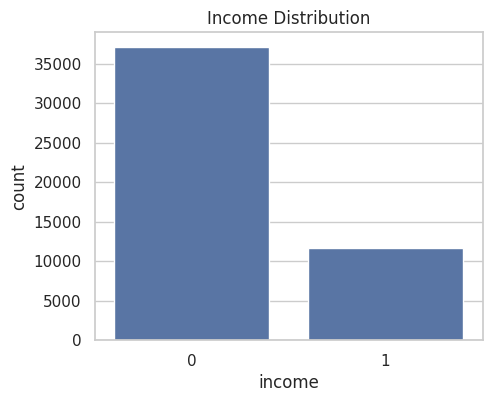


🔍 Insight: The dataset is imbalanced, with the majority earning <=50K.


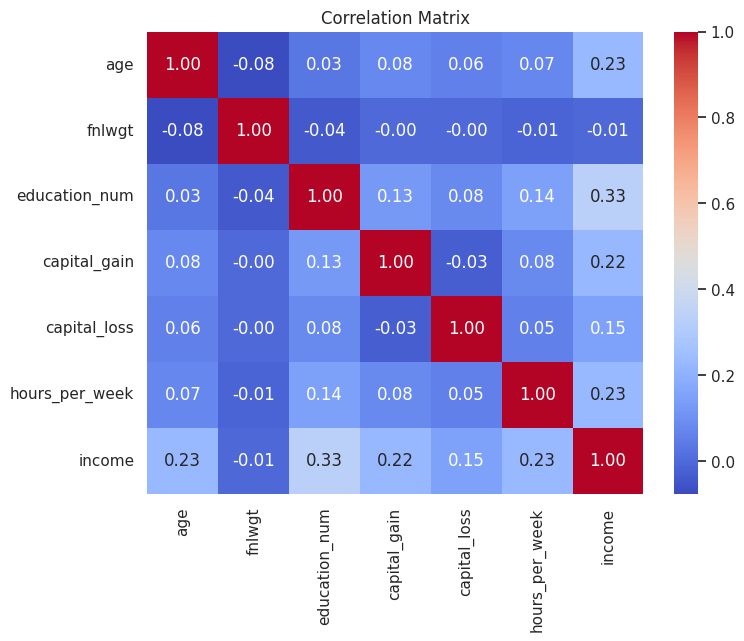

🔍 Insight: Education_num, capital_gain, and hours_per_week have the strongest positive correlation with income.


In [ ]:
# === 3. EXPLORATORY DATA ANALYSIS (EDA) ===
sns.set(style="whitegrid")

# Income distribution
plt.figure(figsize=(5, 4))
sns.countplot(x="income", data=df)
plt.title("Income Distribution")
plt.show()
print("\n🔍 Insight: The dataset is imbalanced, with the majority earning <=50K.")

# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()
print("🔍 Insight: Education_num, capital_gain, and hours_per_week have the strongest positive correlation with income.")

In [ ]:
# === 4. ENCODING & SCALING ===
df_encoded = pd.get_dummies(df, columns=[
    "workclass", "education", "marital_status", "occupation",
    "relationship", "race", "sex", "native_country"
])

# Scale numeric features EXCEPT target
numeric_cols = df_encoded.select_dtypes(include=np.number).columns.tolist()
features_to_scale = [col for col in numeric_cols if col != "income"]

scaler = StandardScaler()
df_encoded[features_to_scale] = scaler.fit_transform(df_encoded[features_to_scale])

In [ ]:
# Save modeling-ready dataset
# df_encoded.to_csv(r"C:\Users\User\Downloads\census+income\cleaned_data_encoded_scaled.csv", index=False)
df_encoded.to_csv(r"C:\Users\celin\OneDrive\Education\USD-MS-ADS\ADS-504\Final-Project\cleaned_raw_full.csv", index=False)


--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      7363
           1       0.73      0.61      0.66      2395

    accuracy                           0.85      9758
   macro avg       0.81      0.77      0.78      9758
weighted avg       0.84      0.85      0.84      9758

Cross-Validation Accuracy (Mean ± Std): 0.8524 ± 0.0024


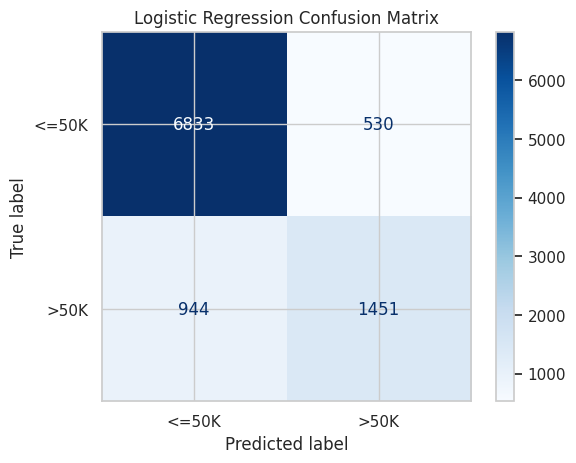


--- Random Forest ---
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      7363
           1       0.72      0.64      0.68      2395

    accuracy                           0.85      9758
   macro avg       0.80      0.78      0.79      9758
weighted avg       0.85      0.85      0.85      9758

Cross-Validation Accuracy (Mean ± Std): 0.8527 ± 0.0018


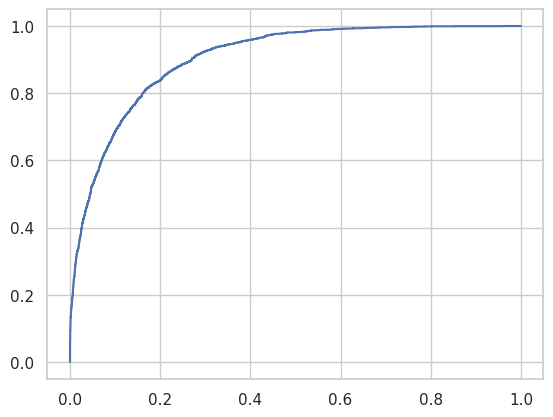

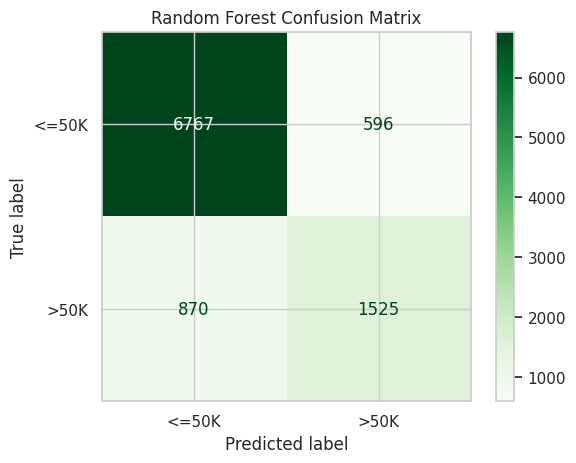

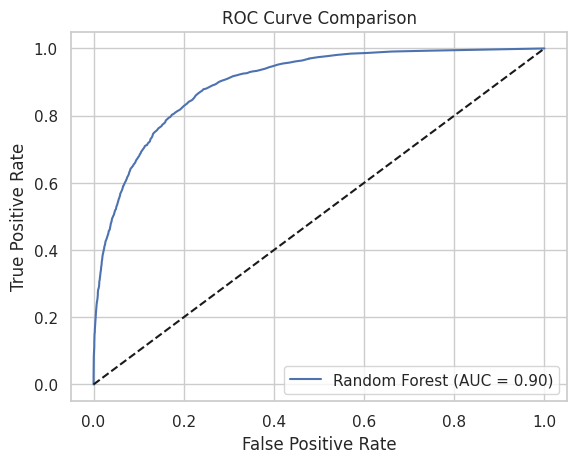


📊 Model Performance Comparison:
                 Model  CV Mean Accuracy  Test Accuracy  Precision    Recall  \
0  Logistic Regression          0.852429       0.848944   0.732458  0.605846   
1        Random Forest          0.852736       0.849764   0.719000  0.636743   

   F1 Score       AUC  
0  0.663163  0.904322  
1  0.675376  0.898896  

✅ Best performing model: Random Forest with 0.8498 accuracy and 0.8989 AUC.
💡 Insight: Logistic Regression is easier to interpret, while Random Forest may capture complex feature interactions better.


In [ ]:
# === 5. TRAIN/TEST SPLIT ===
X = df_encoded.drop("income", axis=1)
y = df_encoded["income"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === 6. MODELING & VALIDATION ===
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42)
}

results = []

for name, model in models.items():
    # Train
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Cross-validation
    cv_scores = cross_val_score(model, X, y, cv=5, scoring="accuracy")

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_prob)

    results.append({
        "Model": name,
        "CV Mean Accuracy": cv_scores.mean(),
        "Test Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "AUC": auc_score
    })

    # Classification report
    print(f"\n--- {name} ---")
    print(classification_report(y_test, y_pred))
    print(f"Cross-Validation Accuracy (Mean ± Std): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    # Confusion Matrix
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=["<=50K", ">50K"]).plot(
        cmap='Blues' if name=="Logistic Regression" else 'Greens'
    )
    plt.title(f"{name} Confusion Matrix")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc(fpr, tpr):.2f})")

# === 7. ROC Curve Comparison ===
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

# === 8. MODEL PERFORMANCE COMPARISON TABLE ===
results_df = pd.DataFrame(results)
print("\n📊 Model Performance Comparison:")
print(results_df)

# === 9. BEST MODEL SELECTION & INSIGHTS ===
best_model = results_df.sort_values(by="Test Accuracy", ascending=False).iloc[0]
print(f"\n✅ Best performing model: {best_model['Model']} "
      f"with {best_model['Test Accuracy']:.4f} accuracy and {best_model['AUC']:.4f} AUC.")
print("💡 Insight: Logistic Regression is easier to interpret, "
      "while Random Forest may capture complex feature interactions better.")